# Packages and Libraries

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Dataset

In [9]:
import cv2
import imghdr
import pathlib # For path 
import os

In [7]:
image_exts = ['jpeg','jpg', 'bmp', 'png']
data_dir = 'data'

## Remove unusable data

In [11]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Image not in ext list data\Adobo\Adobo_512.jpg
Image not in ext list data\Adobo\Adobo_514.jpg
Image not in ext list data\Adobo\Adobo_954.jpg
Image not in ext list data\Pinakbet\pinakbet511.jpg
Image not in ext list data\Pinakbet\pinakbet569.jpg
Image not in ext list data\Pinakbet\pinakbets285.jpg
Image not in ext list data\Pinakbet\pinakbets346.jpg
Image not in ext list data\Sinigang\1200px-Sinigang_na_Baboy.jpg
Image not in ext list data\Sinigang\1XcAyueb9-x8QsmZHFoy3KQ.jpeg
Image not in ext list data\Sinigang\2004_0905Image0028.jpg
Image not in ext list data\Sinigang\22815316_10213179328430751_2530413281339854847_n.jpg
Image not in ext list data\Sinigang\48a443a960094f418a94ca96e9c56338.jpeg
Image not in ext list data\Sinigang\69408499-sinigang-na-hipon-prawn-soup-traditional-filipino-dish.jpg
Image not in ext list data\Sinigang\977509203d0d19f6e87f6edf7cf84856.jpeg720w_406h_1e_1c_1f.webp
Image not in ext list data\Sinigang\aa60be44fe035f39beab1ebd0f432a5f.jpeg960w_540h_1e_1c_1f.webp

In [12]:
data_dir = pathlib.Path(data_dir)

In [18]:
image_count = len(list(data_dir.glob('*/*.*')))
print(f"Total number of images: {image_count}")

Total number of images: 2942


## Create dataset

In [19]:
batch_size = 32
img_height = 180
img_width = 180

Training Dataset

In [20]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2942 files belonging to 3 classes.
Using 2354 files for training.


Validation Dataset

In [21]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2942 files belonging to 3 classes.
Using 588 files for validation.


Print Class

In [23]:
class_names = train_ds.class_names
print(class_names)

['Adobo', 'Pinakbet', 'Sinigang']


## Data Visualization

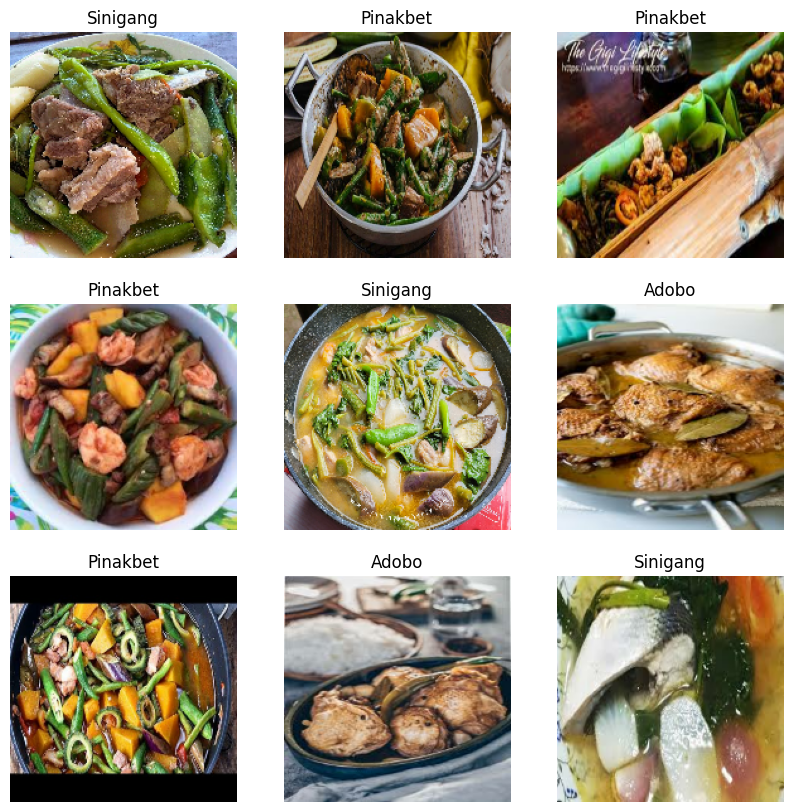

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Batch information

In [28]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure and Standardize the Dataset

In [30]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [31]:
normalization_layer = layers.Rescaling(1./255)

In [32]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


# Model

## Create the Model

In [33]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile the Model

In [34]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model Summary

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

## Training the Model

In [37]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
74/74 [==============================] - 53s 684ms/step - loss: 1.0375 - accuracy: 0.4830 - val_loss: 0.8798 - val_accuracy: 0.6259
Epoch 2/10
74/74 [==============================] - 42s 569ms/step - loss: 0.6624 - accuracy: 0.7349 - val_loss: 0.5815 - val_accuracy: 0.7687
Epoch 3/10
74/74 [==============================] - 41s 561ms/step - loss: 0.5128 - accuracy: 0.8033 - val_loss: 0.5329 - val_accuracy: 0.7993
Epoch 4/10
74/74 [==============================] - 43s 579ms/step - loss: 0.3710 - accuracy: 0.8662 - val_loss: 0.4550 - val_accuracy: 0.8435
Epoch 5/10
74/74 [==============================] - 45s 605ms/step - loss: 0.2326 - accuracy: 0.9218 - val_loss: 0.4394 - val_accuracy: 0.8520
Epoch 6/10
74/74 [==============================] - 42s 573ms/step - loss: 0.1330 - accuracy: 0.9562 - val_loss: 0.5144 - val_accuracy: 0.8401
Epoch 7/10
74/74 [==============================] - 44s 601ms/step - loss: 0.1347 - accuracy: 0.9545 - val_loss: 0.5709 - val_accuracy: 0.8435

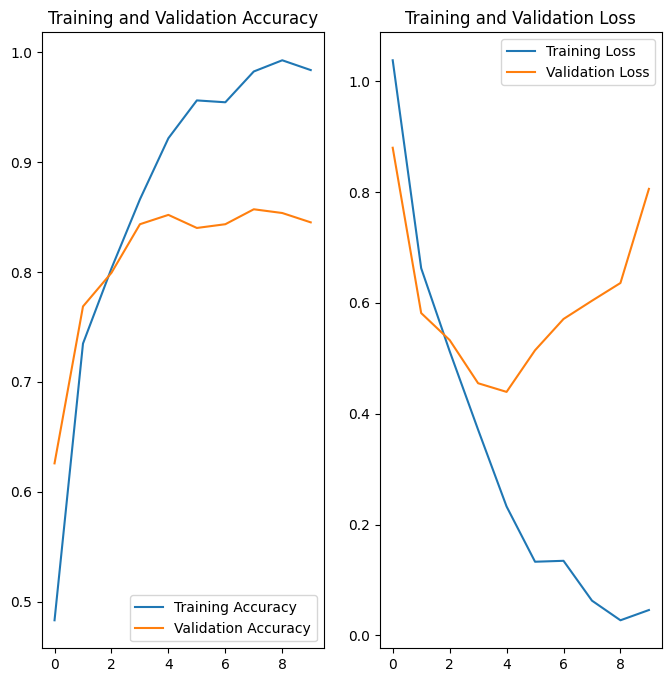

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import cv2

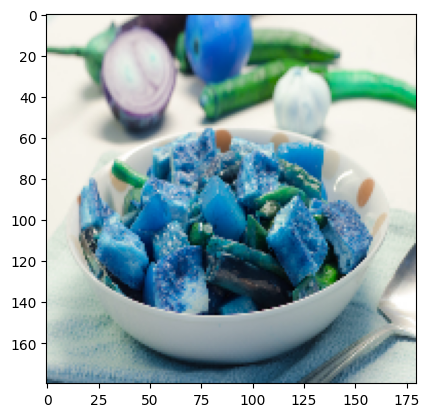

In [47]:
img = cv2.imread('pinakbet1.jpg')

resize = tf.image.resize(img, (180,180))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [48]:
predictions = model.predict(np.expand_dims(resize/255, 0))
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 78ms/step
This image most likely belongs to Pinakbet with a 78.08 percent confidence.


## Regularization (Prevent Overfitting)

### Data Augmentation

In [50]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

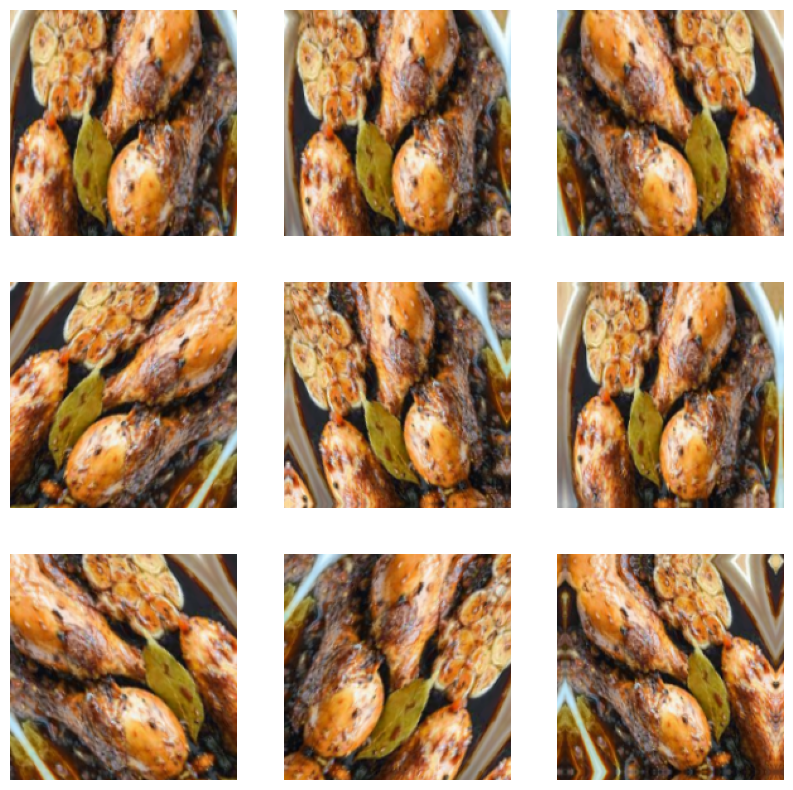

In [51]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Dropout

In [99]:
model = Sequential([
  data_augmentation,
    
  layers.Rescaling(1./255),
    
  layers.Conv2D(16, 3, padding='same', activation='elu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(32, 3, padding='same', activation='elu'),
  layers.MaxPooling2D(),
    
  layers.Dropout(0.2),
    
  layers.Conv2D(64, 3, padding='same', activation='elu'),
  layers.MaxPooling2D(),
    
  layers.Dropout(0.2),
    
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
    
  layers.Dense(num_classes, name="outputs")
])

In [100]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [101]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

In [102]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
74/74 [==============================] - 77s 835ms/step - loss: 1.1780 - accuracy: 0.5573 - val_loss: 0.6930 - val_accuracy: 0.7381
Epoch 2/15
74/74 [==============================] - 62s 834ms/step - loss: 0.7054 - accuracy: 0.7192 - val_loss: 0.7584 - val_accuracy: 0.6956
Epoch 3/15
74/74 [==============================] - 63s 846ms/step - loss: 0.6235 - accuracy: 0.7511 - val_loss: 0.8161 - val_accuracy: 0.6837
Epoch 4/15
74/74 [==============================] - 68s 923ms/step - loss: 0.6267 - accuracy: 0.7472 - val_loss: 0.8261 - val_accuracy: 0.6667
Epoch 5/15
74/74 [==============================] - 63s 846ms/step - loss: 0.6075 - accuracy: 0.7549 - val_loss: 0.7061 - val_accuracy: 0.7313
Epoch 6/15
74/74 [==============================] - 61s 826ms/step - loss: 0.5276 - accuracy: 0.7931 - val_loss: 0.6880 - val_accuracy: 0.7551
Epoch 7/15
74/74 [==============================] - 63s 846ms/step - loss: 0.5072 - accuracy: 0.8118 - val_loss: 0.6343 - val_accuracy: 0.7738

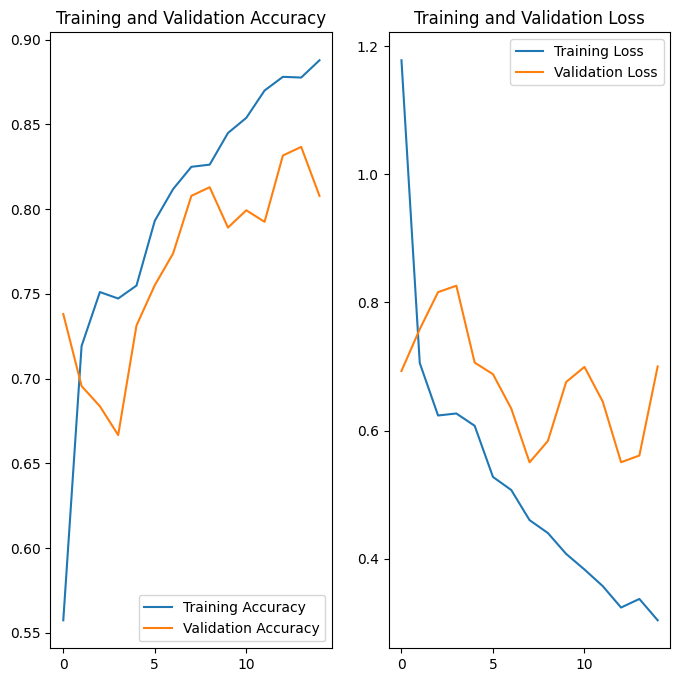

In [103]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

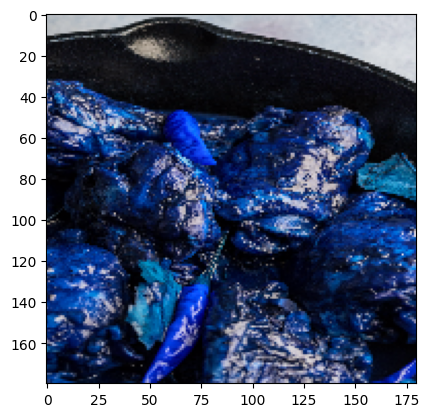

In [104]:
import cv2
img = cv2.imread('adobo.jpg')

resize = tf.image.resize(img, (180,180))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [110]:
predictions = model.predict(np.expand_dims(resize/180, 0))
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
print(score)

1/1 [==============================] - 0s 341ms/step
This image most likely belongs to Adobo with a 99.98 percent confidence.
tf.Tensor([9.9984026e-01 1.1948969e-04 4.0218023e-05], shape=(3,), dtype=float32)


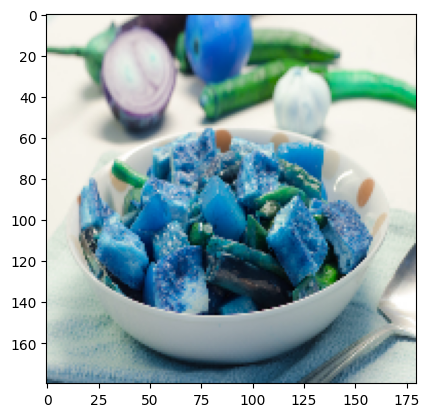

In [106]:
import cv2
img = cv2.imread('pinakbet.jpg')

resize = tf.image.resize(img, (180, 180))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [113]:
predictions = model.predict(np.expand_dims(resize/180, 0))
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
print(score)


1/1 [==============================] - 0s 184ms/step
This image most likely belongs to Adobo with a 99.98 percent confidence.
tf.Tensor([9.9984026e-01 1.1948969e-04 4.0218023e-05], shape=(3,), dtype=float32)
